In [2]:
from langchain_ollama import OllamaEmbeddings, OllamaLLM, ChatOllama
model = ChatOllama(model="llama3.2", temperature=0)

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [3]:

def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [4]:
graph_builder.add_edge(START, "chatbot")

In [5]:
graph_builder.add_edge("chatbot", END)

In [6]:
graph = graph_builder.compile()

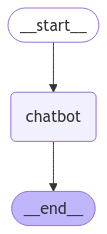

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)




In [9]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I'm happy to help, but it seems like you didn't finish your question. Could you please provide more context or clarify what you're asking? I'll do my best to assist you.
Goodbye!


In [10]:
from langchain_community.tools import DuckDuckGoSearchRun

tool = DuckDuckGoSearchRun()

tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

"Langraph: nodes, states, and edges. At the heart of LangGraph is the concept of a stateful graph:. State: Represents the context or memory that is maintained and updated as the computation ... Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ... In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state ... At the heart of LangGraph's design lies a graph-based representation of the application's workflow. This graph comprises two primary elements: Nodes - The Building Blocks of Work: Each node in a LangGraph represents a distinct unit of work or action within the applic

In [11]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOllama(model="llama3.2", temperature=0)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [12]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [13]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [17]:
route_tools({"messages": [{"content": "What's a 'node' in LangGraph?"}]})

'__end__'

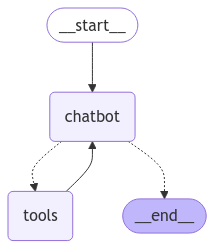

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [28]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: "Learning vocabulary is essential for language learning success, and these websites will help you do so\u2014efficiently!\u2014for free. 22. Duolingo. Available languages: Japanese, Portuguese, Arabic, Welsh, Hebrew, German and more. Duolingo's user-friendly vocabulary games made language learning cool again. There are lots of free language learning resources here, but if you want no ads and extra features, you can pay monthly or yearly to get the Premium Content package. Languages you can learn: Spanish Visit 123TeachMe. 06. of 09. Mango Languages. What We Like. Free in libraries and schools that offer the program. Sometimes, you need resources that are specific to the language you're learning. For example, if you are studying American Sign Language, you really need either a live instructor or videos. iTalki revolutionizes language learning by connecting you directly with over 20,000 certified language teachers and native speakers for one-on-one video lessons. U

In [1]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [4]:
from typing import Annotated

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = DuckDuckGoSearchRun(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.2", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [5]:
graph = graph_builder.compile(checkpointer=memory)

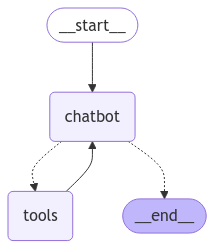

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
config = {"configurable": {"thread_id": "1"}}

In [8]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (84062bb1-7df4-4878-b2ce-e31cd548962f)
 Call ID: 84062bb1-7df4-4878-b2ce-e31cd548962f
  Args:
    query: What is the meaning of a friendly hello?
================================= Tool Message =================================
Name: duckduckgo_search

Learn the meaning of "Hi there" and when to use this casual, friendly greeting. Learn its origins, meaning, appropriate contexts, and alternatives for every communications. ... "Hi there" is a casual way to say hello. It's like giving your words a friendly hug. The "there" doesn't point to a place it's just there to make things warmer. This is a friendly greeting often associated with Australian culture. It's a way of saying "hello" or "good day" to someone in a cheerful and informal manner. For example, you might greet 